## 100 epochs training

* 359/359 [00:15<00:00, 23.51it/s, accuracy=0.987, lr=1e-5, train_loss=0.261]


* 177/177 [00:02<00:00, 91.55it/s, accuracy=0.366, valid_loss=9.8]

In [1]:
import os
import copy
import math
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import _LRScheduler


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import transformers
from transformers import (BertTokenizer, BertModel,
                          DistilBertTokenizer, DistilBertModel)

/home/user/anaconda3/envs/rapids-0.18/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
data_path = '/mnt/hdd1/wearly/kaggle/shopee/'
train= pd.read_csv(data_path+'train.csv')
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


MIN words: 1, MAX words: 61


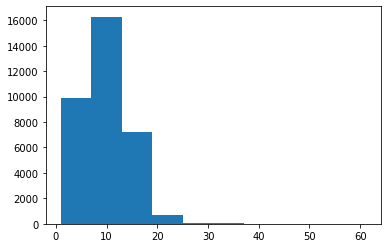

In [3]:
title_lengths = train['title'].apply(lambda x: len(x.split(" "))).to_numpy() #token length check
print(f"MIN words: {title_lengths.min()}, MAX words: {title_lengths.max()}")
plt.hist(title_lengths);

In [4]:
class CFG:
    DistilBERT = True
    bert_hidden_size = 768 #Bert-base
    
    batch_size = 64 #32?
    epochs = 200
    num_workers = 4
    learning_rate= 1e-5 #3e-5
    scheduler = 'ReduceLROnPlateau'
    step = 'epoch'
    patience = 2
    factor = 0.8
    dropout = 0.5
    model_path = '/mnt/hdd1/wearly/ethan/shopee/Train/weights/distil4'
    max_length = 30 #변경가능
    model_save_name = "epochs_distillbert.pt"
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [5]:
if CFG.DistilBERT:
    model_name='cahya/distilbert-base-indonesian'
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    bert_model = DistilBertModel.from_pretrained(model_name)
else:
    model_name='cahya/bert-base-indonesian-522M'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    bert_model = BertModel.from_pretrained(model_name)

In [6]:
text = train['title'].values[np.random.randint(0, len(train) - 1, 1)[0]]
print(f"Text of the title: {text}")
encoded_input = tokenizer(text, return_tensors='pt')
print(f"Input tokens: {encoded_input['input_ids']}")
decoded_input = tokenizer.decode(encoded_input['input_ids'][0])
print(f"Decoded tokens: {decoded_input}")
output = bert_model(**encoded_input)
print(f"last layer's output shape: {output.last_hidden_state.shape}")

Text of the title: Alat Pemisah Putih Kuning Telur Egg Separator
Input tokens: tensor([[    3,  3342, 26024,  3371,  5261,  5828, 29792, 18765,  2699,     1]])
Decoded tokens: [CLS] alat pemisah putih kuning telur egg separator [SEP]
last layer's output shape: torch.Size([1, 10, 768])


### Dataset

label_group을 numeric하게 인코딩

In [7]:
lbl_encoder = LabelEncoder()
train['label_code'] = lbl_encoder.fit_transform(train['label_group'])
NUM_CLASSES = train['label_code'].nunique()

In [8]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, mode="train", max_length=None):
        self.dataframe = dataframe
        if mode != "test":
            self.targets = dataframe['label_code'].values
        texts = list(dataframe['title'].apply(lambda o: str(o)).values)
        self.encodings = tokenizer(texts, 
                                   padding=True, 
                                   truncation=True, 
                                   max_length=max_length)
        self.mode = mode
        
        
    def __getitem__(self, idx):
        # putting each tensor in front of the corresponding key from the tokenizer
        # HuggingFace tokenizers give you whatever you need to feed to the corresponding model
        item = {key: torch.tensor(values[idx]) for key, values in self.encodings.items()}
        # when testing, there are no targets so we won't do the following
        if self.mode != "test":
            item['labels'] = torch.tensor(self.targets[idx]).long()
        return item
    
    def __len__(self):
        return len(self.dataframe)

In [9]:
# dataset = TextDataset(train.sample(1000), tokenizer, max_length=CFG.max_length)
# dataloader = torch.utils.data.DataLoader(dataset, 
#                                          batch_size=CFG.batch_size, 
#                                          num_workers=CFG.num_workers, 
#                                          shuffle=True)
# batch = next(iter(dataloader))
# print(batch['input_ids'].shape, batch['labels'].shape) #batch, length

In [10]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=CFG.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output

In [11]:
class Model(nn.Module):
    def __init__(self, 
                 bert_model, 
                 num_classes=NUM_CLASSES, 
                 last_hidden_size=CFG.bert_hidden_size):
        
        super().__init__()
        self.bert_model = bert_model
        self.arc_margin = ArcMarginProduct(last_hidden_size, 
                                           num_classes, 
                                           s=30.0, 
                                           m=0.50, 
                                           easy_margin=False)
    
    def get_bert_features(self, batch):
        output = self.bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        last_hidden_state = output.last_hidden_state # shape: (batch_size, seq_length, bert_hidden_dim)
        CLS_token_state = last_hidden_state[:, 0, :] # obtaining CLS token state which is the first token.
        return CLS_token_state
    
    def forward(self, batch):
        CLS_hidden_state = self.get_bert_features(batch)
        output = self.arc_margin(CLS_hidden_state, batch['labels'])
        return output

In [12]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()
    
    def reset(self):
        self.avg, self.sum, self.count = [0]*3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count
    
    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def one_epoch(model, 
              criterion, 
              loader,
              optimizer=None, 
              lr_scheduler=None, 
              mode="train", 
              step="batch"):
    
    loss_meter = AvgMeter()
    acc_meter = AvgMeter()
    
    tqdm_object = tqdm(loader, total=len(loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items()}
        preds = model(batch)
        loss = criterion(preds, batch['labels'])
        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step == "batch":
                lr_scheduler.step()
                
        count = batch['input_ids'].size(0)
        loss_meter.update(loss.item(), count)
        
        accuracy = get_accuracy(preds.detach(), batch['labels'])
        acc_meter.update(accuracy.item(), count)
        if mode == "train":
            tqdm_object.set_postfix(train_loss=loss_meter.avg, accuracy=acc_meter.avg, lr=get_lr(optimizer))
        else:
            tqdm_object.set_postfix(valid_loss=loss_meter.avg, accuracy=acc_meter.avg)
    
    return loss_meter, acc_meter

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

def get_accuracy(preds, targets):
    """
    preds shape: (batch_size, num_labels)
    targets shape: (batch_size)
    """
    preds = preds.argmax(dim=1)
    acc = (preds == targets).float().mean()
    return acc

In [13]:
def train_eval(epochs, model, train_loader, valid_loader, 
               criterion, optimizer, lr_scheduler=None):
    
    best_loss = float('inf')
    best_model_weights = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        print("*" * 30)
        print(f"Epoch {epoch + 1}")
        current_lr = get_lr(optimizer)
        
        model.train()
        train_loss, train_acc = one_epoch(model, 
                                          criterion, 
                                          train_loader, 
                                          optimizer=optimizer,
                                          lr_scheduler=lr_scheduler,
                                          mode="train",
                                          step=CFG.step)                     
        model.eval()
        with torch.no_grad():
            valid_loss, valid_acc = one_epoch(model, 
                                              criterion, 
                                              valid_loader, 
                                              optimizer=None,
                                              lr_scheduler=None,
                                              mode="valid")
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'{CFG.model_path}/{epoch+1}_{CFG.model_save_name}')
            path_name = f'{CFG.model_path}/{epoch+1}_{CFG.model_save_name}'
            print("Saved best model!")
        
        if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_scheduler.step(valid_loss.avg)
            if current_lr != get_lr(optimizer):
                print("Loading best model weights!")
                model.load_state_dict(torch.load(path_name, 
                                                 map_location=CFG.device))
        
        print("*" * 30)

In [14]:
train_df, valid_df = train_test_split(train, 
                                      test_size=0.33, 
                                      shuffle=True, 
                                      random_state=42, 
                                      stratify=train['label_code'])

train_dataset = TextDataset(train_df, tokenizer, max_length=CFG.max_length)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=CFG.batch_size, 
                                           num_workers=CFG.num_workers, 
                                           shuffle=True)

valid_dataset = TextDataset(valid_df, tokenizer, max_length=CFG.max_length)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=CFG.batch_size, 
                                           num_workers=CFG.num_workers, 
                                           shuffle=False)

In [15]:
model = Model(bert_model).to(CFG.device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)
if CFG.scheduler == "ReduceLROnPlateau":
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                              mode="min", 
                                                              factor=CFG.factor, 
                                                              patience=CFG.patience)

train_eval(CFG.epochs, model, train_loader, valid_loader,
           criterion, optimizer, lr_scheduler=lr_scheduler)

******************************
Epoch 1


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 2


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 3


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 4


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 5


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 6


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 7


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 8


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 9


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 10


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 11


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 12


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 13


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 14


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 15


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 16


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 17


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 18


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 19


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 20


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 21


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 22


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 23


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 24


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 25


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 26


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 27


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 28


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 29


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 30


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 31


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 32


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 33


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 34


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 35


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 36


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 37


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 38


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 39


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 40


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 41


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 42


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 43


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 44


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 45


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 46


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 47


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 48


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 49


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 50


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 51


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 52


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 53


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 54


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 55


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 56


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 57


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 58


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 59


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 60


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 61


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 62


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 63


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 64


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 65


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 66


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 67


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 68


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 69


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 70


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 71


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 72


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 73


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 74


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 75


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 76


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 77


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 78


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 79


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 80


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 81


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 82


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 83


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 84


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 85


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 86


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 87


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 88


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 89


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 90


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 91


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 92


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 93


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 94


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 95


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 96


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 97


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 98


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 99


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 100


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 101


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 102


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 103


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 104


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 105


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 106


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 107


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 108


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 109


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 110


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 111


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 112


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 113


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 114


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 115


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 116


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 117


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 118


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 119


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 120


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 121


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 122


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 123


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 124


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 125


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 126


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 127


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 128


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 129


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 130


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 131


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Loading best model weights!
******************************
******************************
Epoch 132


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 133


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 134


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 135


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 136


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 137


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Loading best model weights!
******************************
******************************
Epoch 138


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 139


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 140


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 141


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 142


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 143


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 144


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 145


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Loading best model weights!
******************************
******************************
Epoch 146


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 147


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 148


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 149


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 150


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 151


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 152


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
Loading best model weights!
******************************
******************************
Epoch 153


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 154


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 155


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 156


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 157


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 158


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 159


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 160


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 161


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 162


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 163


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
Loading best model weights!
******************************
******************************
Epoch 164


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 165


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 166


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 167


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 168


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 169


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 170


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
Loading best model weights!
******************************
******************************
Epoch 171


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 172


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 173


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 174


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 175


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 176


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 177


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
Loading best model weights!
******************************
******************************
Epoch 178


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 179


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 180


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 181


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Loading best model weights!
******************************
******************************
Epoch 182


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 183


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 184


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 185


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 186


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 187


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 188


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 189


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 190


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 191


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 192


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 193


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 194


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 195


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
Loading best model weights!
******************************
******************************
Epoch 196


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 197


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 198


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 199


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

******************************
******************************
Epoch 200


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Loading best model weights!
******************************


In [16]:
# !mkdir tokenizer
# tokenizer.save_pretrained("./tokenizer")
# torch.save(model.state_dict(), "final.pt")